In [1]:
# Usual imports
import os
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline

## Import data using the wfdb package

In [2]:
# Software package for handling the database
import wfdb

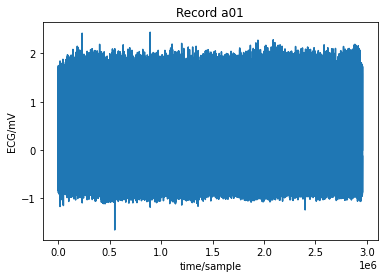

In [3]:
# Read in a recording, plot it, and show its dictionary.
record = wfdb.rdrecord('./data/a01')
wfdb.plot_wfdb(record=record, title='Record a01') 
#display(record.__dict__)

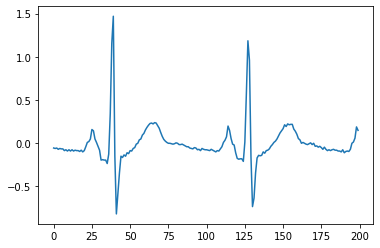

In [4]:
# Alternatively, convert signal to numpy array and plot only a part of it.
plt.plot(record.__dict__['p_signal'][:200])

In [5]:
# Read in annotations.
annotation = wfdb.rdann('./data/a01', 'apn')
#print(annotation.__dict__)

In [8]:
len(annotation.__dict__["sample"]) - 1

488

In [ ]:
list(range(len()))

## Create data matrix

In [7]:
from lib import models, graph, coarsening, utils

/home/agarmanv/Documents/cnn_graph/lib/graph.py:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert metric is 'cosine'
/home/agarmanv/Documents/cnn_graph/lib/graph.py:155: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algo is 'eig':
/home/agarmanv/Documents/cnn_graph/lib/graph.py:158: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algo is 'eigh':
/home/agarmanv/Documents/cnn_graph/lib/graph.py:160: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algo is 'eigs':
/home/agarmanv/Documents/cnn_graph/lib/graph.py:163: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif algo is 'eigsh':
/home/agarmanv/Documents/cnn_graph/lib/coarsening.py:192: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(indices_node) is 1:
/home/agarmanv/Documents/cnn_graph/lib/coarsening.py:197: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif len(indices_node) is 0:
/home/agarmanv/Documents/cnn_graph/lib/utils.py:18: Synta

In [10]:
# List of recordings
reclist = ['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10']#,'a11','a12','a13','a14','a15','a16','a17','a18','a19','a20']

# Data and label matrix recordings
n_of_hours = 7
n_of_mins = n_of_hours*60
n_of_samples = n_of_mins * 60 * 100
data = np.zeros((len(reclist),n_of_samples))
labels = np.zeros((len(reclist),n_of_mins))

# Read in recordings and annotations.
for r in range(len(reclist)):
    record = wfdb.rdrecord(os.path.join(".", "data", reclist[r]), sampto=n_of_samples)
    data[r,:] = record.__dict__['p_signal'].flatten()
    
    annotation = wfdb.rdann(os.path.join(".", "data", reclist[r]), 'apn', sampto=n_of_samples)
    label_help = np.asarray(annotation.__dict__['symbol'])[:n_of_mins]
    labels[r,:] = np.where(label_help=='N',0,1)
    
print(data.shape)
print(labels.shape)

(10, 2520000)
(10, 420)


In [11]:
# Create data matrix.
dx = 300  # I chose this arbitrarily.
n = len(reclist)*n_of_hours*60
X = np.zeros((n,dx))
for i in range(data.shape[0]):
    for j in range(n_of_mins):
        X[i*n_of_mins+j,:] = data[i,j*6000:j*6000+300]
y = labels.flatten()
        
print(X.shape)
print(y.shape)

(4200, 300)
(4200,)


In [17]:
# # Normalize data. Is this necessary/useful? 
# X = X - X.mean(axis=1)[:,np.newaxis]
# X = 1/(1 + np.exp(-X)) - 0.5

In [14]:
# Normalize to be between 0 and 1
X = (X - np.min(X)) / (np.max(X) - np.min(X))

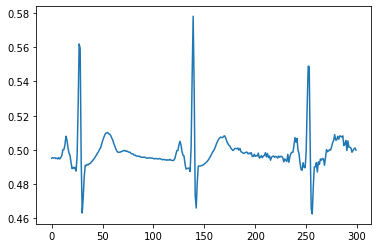

In [18]:
# Plot examples.
sample = 100
plt.plot(X[sample])

In [19]:
# Split into training and validation set.
size_train = 8
size_val = 2
X_train = X[:size_train*n_of_mins,:].astype(np.float32)
y_train = y[:size_train*n_of_mins].astype(np.uint8)
X_val = X[size_train*n_of_mins:,:].astype(np.float32)
y_val = y[size_train*n_of_mins:].astype(np.uint8)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3360, 300)
(3360,)
(840, 300)
(840,)


# Run a baseline model

In [22]:
import torch

ModuleNotFoundError: No module named 'torch'

## Natural graph architecture

In [15]:
import sklearn
dx = 300
end = dx-1
grid = np.linspace(0,end,dx)
#print('grid:\n',grid)

dist = np.zeros((dx,dx))
for i in range(dx):
    for j in range(dx):
        distance = np.abs(grid[i]-grid[j])
        if distance <= end/2:
            dist[i,j] = np.abs(grid[i]-grid[j])
        else:
            dist[i,j] = end - np.abs(grid[i]-grid[j]) + end/(dx-1)
#print('distances: \n',dist)

In [16]:
k = 2
idx = np.argsort(dist)[:,1:k+1]
#print('idx:\n',idx)
dist.sort()
dist = dist[:,1:k+1]
#print('dist:\n',dist)

In [17]:
a = graph.adjacency(dist,idx).astype(np.float32)
#plt.spy(a,markersize=4,color='black')

In [18]:
graphs, perm = coarsening.coarsen(a, levels=6, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)
X_val = coarsening.perm_data(X_val, perm)

Layer 0: M_0 = |V| = 640 nodes (340 added),|E| = 300 edges
Layer 1: M_1 = |V| = 320 nodes (153 added),|E| = 167 edges
Layer 2: M_2 = |V| = 160 nodes (66 added),|E| = 94 edges
Layer 3: M_3 = |V| = 80 nodes (27 added),|E| = 53 edges
Layer 4: M_4 = |V| = 40 nodes (9 added),|E| = 31 edges
Layer 5: M_5 = |V| = 20 nodes (2 added),|E| = 18 edges
Layer 6: M_6 = |V| = 10 nodes (0 added),|E| = 10 edges


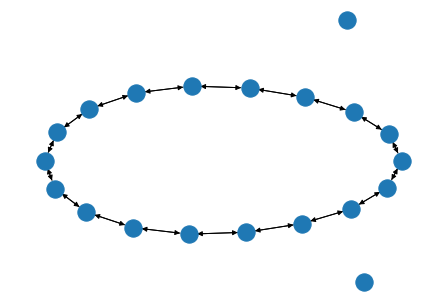

In [19]:
import networkx as nx
# Illustrate graph (details not important).
G = nx.from_numpy_matrix(np.matrix(graphs[5].toarray()), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout)
plt.show()

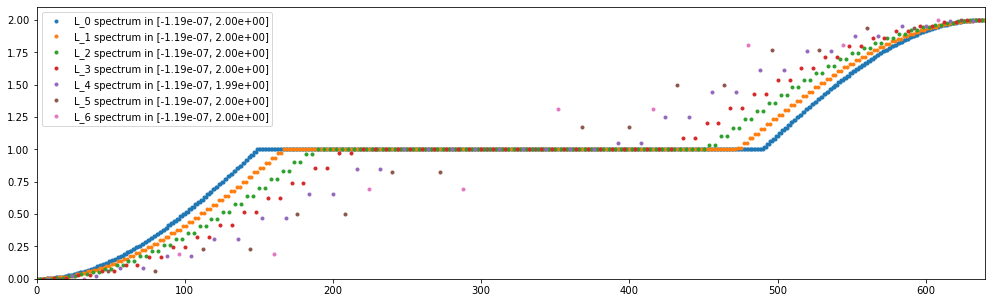

In [20]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

## Training

In [22]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 20
params['batch_size']     = int(X_train.shape[0]/100)
params['eval_frequency'] = 10

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = int(y.max() + 1)
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 32, 32]  # Number of graph convolutional filters.
params['K']              = [20, 20, 20]  # Polynomial orders.
params['p']              = [4, 4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-2
params['dropout']        = 1
params['learning_rate']  = 1e-4 
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = X_train.shape[0] / params['batch_size']

In [23]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

NN architecture
  input: M_0 = 640
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 640 * 32 / 4 = 5120
    weights: F_0 * F_1 * K_1 = 1 * 32 * 20 = 640
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 160 * 32 / 4 = 1280
    weights: F_1 * F_2 * K_2 = 32 * 32 * 20 = 20480
    biases: F_2 = 32
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 40 * 32 / 2 = 640
    weights: F_2 * F_3 * K_3 = 32 * 32 * 20 = 20480
    biases: F_3 = 32
  layer 4: fc1
    representation: M_4 = 512
    weights: M_3 * M_4 = 640 * 512 = 327680
    biases: M_4 = 512
  layer 5: logits (softmax)
    representation: M_5 = 2
    weights: M_4 * M_5 = 512 * 2 = 1024
    biases: M_5 = 2


W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.


step 10 / 2036 (epoch 0.10 / 20):
  learning_rate = 1.00e-04, loss_average = 4.19e+01
  validation accuracy: 45.48 (382 / 840), f1 (weighted): 28.57, loss: 6.57e+01
  time: 33s (wall 5s)
step 20 / 2036 (epoch 0.20 / 20):
  learning_rate = 1.00e-04, loss_average = 5.64e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.57e+01
  time: 67s (wall 9s)
step 30 / 2036 (epoch 0.29 / 20):
  learning_rate = 1.00e-04, loss_average = 6.15e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.56e+01
  time: 100s (wall 13s)
step 40 / 2036 (epoch 0.39 / 20):
  learning_rate = 1.00e-04, loss_average = 6.32e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.55e+01
  time: 134s (wall 18s)
step 50 / 2036 (epoch 0.49 / 20):
  learning_rate = 1.00e-04, loss_average = 6.37e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.55e+01
  time: 166s (wall 22s)
step 60 / 2036 (epoch 0.59 / 20):
  learning_rate = 1.00e-0

  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.33e+01
  time: 1467s (wall 192s)
step 450 / 2036 (epoch 4.42 / 20):
  learning_rate = 8.15e-05, loss_average = 6.18e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.32e+01
  time: 1500s (wall 196s)
step 460 / 2036 (epoch 4.52 / 20):
  learning_rate = 8.15e-05, loss_average = 6.18e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.31e+01
  time: 1533s (wall 200s)
step 470 / 2036 (epoch 4.62 / 20):
  learning_rate = 8.15e-05, loss_average = 6.17e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.31e+01
  time: 1567s (wall 205s)
step 480 / 2036 (epoch 4.71 / 20):
  learning_rate = 8.15e-05, loss_average = 6.16e+01
  validation accuracy: 45.36 (381 / 840), f1 (weighted): 28.31, loss: 6.31e+01
  time: 1600s (wall 209s)
step 490 / 2036 (epoch 4.81 / 20):
  learning_rate = 8.15e-05, loss_average = 6.16e+01
  validation accuracy: 45.36 (381 / 840)

KeyboardInterrupt: 

## Create graph as in usage.ipynb

In [ ]:
dist, idx = graph.distance_scipy_spatial(X_train.T, k=2, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

plt.spy(A, markersize=2, color='black');

In [ ]:
graphs, perm = coarsening.coarsen(A, levels=7, self_connections=False)

X_train = coarsening.perm_data(X_train, perm)

In [ ]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)